## Importy

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin


## Načítavať a predspracovávať dáta

In [40]:
# Načítanie datasetu 'sales_data.csv' do DataFrame pomocou pandas
df = pd.read_csv('sales_data.csv')

# Vytvorenie OrdinalEncoder pre vekové skupiny. Vekové kategórie sú zoradené od najmladšej po najstaršiu
ordinal_encoder = OrdinalEncoder(categories=[['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']])

# Aplikácia ordinal encodingu na stĺpec 'Age_Group', čím sa kategórie prevedú na číselné hodnoty
df['Age_Group_Encoded'] = ordinal_encoder.fit_transform(df[['Age_Group']])

# Prevod stĺpca 'Country' na číselné hodnoty pomocou LabelEncoder
df['Country_Encoded'] = LabelEncoder().fit_transform(df['Country'])

# Prevod stĺpca 'State' na číselné hodnoty pomocou LabelEncoder
df['State_Encoded'] = LabelEncoder().fit_transform(df['State'])

# Prevod stĺpca 'Product_Category' na číselné hodnoty pomocou LabelEncoder
df['Product_Category_Encoded'] = LabelEncoder().fit_transform(df['Product_Category'])

# Prevod stĺpca 'Sub_Category' na číselné hodnoty pomocou LabelEncoder
df['Sub_Category_Encoded'] = LabelEncoder().fit_transform(df['Sub_Category'])

# Prevod stĺpca 'Customer_Gender' na číselné hodnoty pomocou LabelEncoder
df['Customer_Gender_encoded'] = LabelEncoder().fit_transform(df['Customer_Gender'])

# Výber vstupných premenných a ich transformácia na numpy array pre trénovanie modelu
X = df[['Customer_Age', 'Age_Group_Encoded', 'Country_Encoded', 'State_Encoded', 
        'Product_Category_Encoded', 'Sub_Category_Encoded', 'Order_Quantity', 
        'Profit', 'Revenue']].values  

# Získanie cieľovej premennej (Customer_Gender_encoded) ako 1D numpy array
y = df['Customer_Gender_encoded'].values

# Zobrazenie tvaru matice vstupov X a vektora cieľových hodnôt y
X.shape, y.shape


((113036, 9), (113036,))

## Rozdeľovať dáta na trénovaciu a testovaciu množinu

In [41]:
# Rozdelenie dát na trénovaciu a testovaciu množinu. Testovacia množina bude 20% z celkových dát.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Zobrazenie tvarov trénovacej a testovacej množiny pre vstupy (X) a výstupy (y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((90428, 9), (22608, 9), (90428,), (22608,))

## Normalizácia dat

In [42]:
# Inicializácia scaleru (StandardScaler), ktorý štandardizuje dáta tak, aby mali nulový priemer a jednotkovú smerodajnú odchýlku
scaler = StandardScaler()

# Aplikácia scaleru na trénovacie dáta. fit_transform spočíta štatistiky (priemer a odchýlku) a následne dáta transformuje
X_train_scaled = scaler.fit_transform(X_train)

# Transformácia testovacích dát pomocou scaleru, ktorý používa štatistiky vypočítané na trénovacích dátach (bez volania fit)
X_test_scaled = scaler.transform(X_test)

# Zobrazenie tvaru škálovaných trénovacích a testovacích vstupných dát (X) a cieľových hodnôt (y)
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((90428, 9), (22608, 9), (90428,), (22608,))

## Dataset / Dataloader

In [43]:
# Definícia triedy CustomerGenderDataset, ktorá dedí z PyTorch triedy Dataset. Slúži na vytvorenie datasetu pre trénovanie modelu.
class CustomerGenderDataset(Dataset):
    
    # Inicializačná metóda triedy, ktorá prijíma vstupné dáta (X_features) a cieľové dáta (y_labels)
    def __init__(self, X_features, y_labels):
        # Konvertuje vstupné vlastnosti na tensor typu FloatTensor
        self.X_tensors = torch.FloatTensor(X_features)
        # Konvertuje cieľové labely na tensor typu FloatTensor
        self.y_tensors = torch.FloatTensor(y_labels)

    # Metóda vracia počet vzoriek v datasetu (počet riadkov X_tensors)
    def __len__(self):
        return len(self.X_tensors)

    # Metóda vracia konkrétnu vzorku na danom indexe (idx) z datasetu
    def __getitem__(self, idx):
        return self.X_tensors[idx], self.y_tensors[idx]


# Vytvorenie trénovacieho datasetu s použitím škálovaných trénovacích dát a ich labelov
train_dataset = CustomerGenderDataset(X_train_scaled, y_train)

# Vytvorenie validačného datasetu s použitím škálovaných testovacích dát a ich labelov
val_dataset = CustomerGenderDataset(X_test_scaled, y_test)

# Definovanie DataLoader pre trénovanie, ktorý rozdelí dataset na minibatch-e a umožní náhodné premiešanie dát (shuffle)
train_loader = DataLoader(train_dataset, batch_size=960, shuffle=True)

# Definovanie DataLoader pre validáciu, ktorý rozdelí dataset na minibatch-e bez náhodného premiešania
val_loader = DataLoader(val_dataset, batch_size=960, shuffle=False)

# Prechádzanie cez prvý batch dát v trénovacom loade a vypísanie tvaru vstupných dát a cieľových labelov
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}')  # Vypíše tvar vstupných tensorov v batchi (960 vzoriek, počet vstupných vlastností)
    print(f'Targets: {targets.shape}')  # Vypíše tvar cieľových tensorov (960 vzoriek, 1 cieľová hodnota)
    break  # Ukončí slučku po prvom batchi

# Prechádzanie cez prvý batch dát vo validačnom loade a vypísanie tvaru vstupných dát a cieľových labelov
for inputs, targets in val_loader:
    print(f'Inputs: {inputs.shape}')  # Vypíše tvar vstupných tensorov v batchi
    print(f'Targets: {targets.shape}')  # Vypíše tvar cieľových tensorov
    break  # Ukončí slučku po prvom batchi


Inputs: torch.Size([960, 9])
Targets: torch.Size([960])
Inputs: torch.Size([960, 9])
Targets: torch.Size([960])


## Architektúra modelu

In [44]:
# Definícia triedy CustomerGenderNN, ktorá dedí z nn.Module, čo je základná trieda pre všetky neurónové siete v PyTorch
class CustomerGenderNN(nn.Module):
    def __init__(self, in_features=9, h1=92, h2=80, h3=40, dropout2=0.2, dropout3=0.15, out_features=1):
        # Volanie základnej triedy nn.Module, čo je povinné v PyTorch modeloch
        super(CustomerGenderNN, self).__init__()
        
        # Definovanie prvej lineárnej vrstvy s počtom vstupných neurónov rovnakým ako počet vlastností (9) a počtom výstupov (h1 = 92)
        self.layer1 = nn.Linear(in_features, h1)
        # Pridanie batch normy pre prvú vrstvu, ktorá stabilizuje tréning normalizovaním aktivácií
        self.batchnorm1 = nn.BatchNorm1d(h1)
        
        # Definovanie druhej lineárnej vrstvy s počtom vstupov z predchádzajúcej vrstvy (h1) a počtom výstupov (h2 = 80)
        self.layer2 = nn.Linear(h1, h2)
        # Pridanie batch normy pre druhú vrstvu
        self.batchnorm2 = nn.BatchNorm1d(h2)
        # Pridanie dropout regularizácie pre druhú vrstvu, ktorá náhodne "vypína" neuróny s pravdepodobnosťou 0.2, aby sa predišlo preučeniu (overfitting)
        self.dropout2 = nn.Dropout(dropout2)

        # Definovanie tretej lineárnej vrstvy s počtom vstupov z druhej vrstvy (h2) a počtom výstupov (h3 = 40)
        self.layer3 = nn.Linear(h2, h3)
        # Pridanie batch normy pre tretiu vrstvu
        self.batchnorm3 = nn.BatchNorm1d(h3)
        # Pridanie dropout regularizácie pre tretiu vrstvu, s pravdepodobnosťou vypnutia 0.15
        self.dropout3 = nn.Dropout(dropout3)

        # Definovanie výstupnej vrstvy s počtom vstupov z tretej vrstvy (h3) a počtom výstupov (out_features = 1), čo je výsledok binárnej klasifikácie
        self.output = nn.Linear(h3, out_features)
        
    # Definícia forward prechodu (dopredného výpočtu)
    def forward(self, x):
        # Prvá lineárna vrstva + batch norm + ReLU aktivačná funkcia (ReLU zavádza nelinearitu do modelu)
        x = torch.relu(self.batchnorm1(self.layer1(x)))
        
        # Druhá lineárna vrstva + batch norm + ReLU aktivačná funkcia + dropout
        x = torch.relu(self.batchnorm2(self.layer2(x)))
        x = self.dropout2(x)
        
        # Tretia lineárna vrstva + batch norm + ReLU aktivačná funkcia + dropout
        x = torch.relu(self.batchnorm3(self.layer3(x)))
        x = self.dropout3(x)

        # Výstupná vrstva, ktorá nemá aktivačnú funkciu, pretože pre binárnu klasifikáciu môže byť aplikovaný sigmoid mimo tejto vrstvy
        x = self.output(x)
        
        # Vrátenie finálneho výstupu modelu
        return x


## Najdenie najlepsich hyperparametrov

In [25]:

# Obal pre PyTorch model
class PyTorchNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, in_features=9, h1=36, h2=24, h3=16, out_features=1, lr=0.001, weight_decay=0.0001, dropout2=0.1, dropout3=0.1, num_epochs=95, batch_size=928):
        self.in_features = in_features
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.out_features = out_features
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout2 = dropout2
        self.dropout3 = dropout3
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.model = None
        self.optimizer = None
        self.criterion = nn.BCEWithLogitsLoss()

    def fit(self, X, y):
        # Konverzia vstupov do PyTorch tensorov
        X_train = torch.FloatTensor(X)
        y_train = torch.FloatTensor(y)

        # Vytvorenie modelu
        self.model = CustomerGenderNN(
            in_features=self.in_features, h1=self.h1, h2=self.h2, h3=self.h3,
            out_features=self.out_features,
            dropout2=self.dropout2, dropout3=self.dropout3
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        # Prevod dát na dataset a dataloader
        train_dataset = CustomerGenderDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Tréning modelu
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs).squeeze()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

    def predict(self, X):
        X_test = torch.FloatTensor(X)
        self.model.eval()
        with torch.inference_mode():
            outputs = self.model(X_test).squeeze()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
        return preds.cpu().numpy()

    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)


# Definovanie rozsahu hodnôt pre hyperparametre
param_dist = {
    'h1': [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96],
    'h2': [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96],
    'h3': [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96],
    'lr': [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005],
    'weight_decay': [1e-5, 15e-5, 2e-5, 25e-5, 3e-5, 35e-5, 4e-5, 45e-5, 5e-5],
    'dropout2': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'dropout3': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'num_epochs': [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
    'batch_size': [896, 928, 960, 992, 1024, 1056],
}

# Inicializácia obaleného modelu
model = PyTorchNNWrapper()

# Inicializácia RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,  # tu musí byť obalený PyTorch model
    param_distributions=param_dist,
    n_iter=15,  # Skúsi 20 náhodných kombinácií
    # scoring='accuracy',  # Použije accuracy ako metriku
    cv=4,  # Použije 5-násobnú cross-validation
    verbose=2,
    n_jobs=-1,  # Využije všetky dostupné procesory
    random_state=42  # Reprodukovateľné výsledky
)

# Spustenie vyhľadávania hyperparametrov
random_search.fit(X_train_scaled, y_train)

# Zobrazenie najlepších parametrov
print("\nNajlepšie parametre: ", random_search.best_params_)

# Zobrazenie najlepšieho skóre
print("\nNajlepšie skóre (accuracy): ", random_search.best_score_)

# Zobrazenie celkových výsledkov
# results_df = pd.DataFrame(random_search.cv_results_)
# print(results_df[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])

# Vyhodnotenie modelu s najlepšími parametrami
best_model = random_search.best_estimator_
# Tento objekt predstavuje model trénovaný s najlepšími hyperparametrami. Môžeš ho použiť priamo na predikcie na testovacej sade alebo na ďalšiu analýzu.

# Uloženie modelu
joblib.dump(best_model, 'best_model.pkl')

# Nacitanie modelu
# best_model = joblib.load('best_model.pkl')

score = best_model.score(X_test_scaled, y_test)
print("\nTestovacia presnosť s najlepšími parametrami:", score)
print()

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] END batch_size=896, dropout2=0.5, dropout3=0.1, h1=68, h2=52, h3=68, lr=0.0015, num_epochs=96, weight_decay=3e-05; total time= 2.1min
[CV] END batch_size=960, dropout2=0.15, dropout3=0.35, h1=64, h2=56, h3=60, lr=0.004, num_epochs=90, weight_decay=2e-05; total time= 1.7min
[CV] END batch_size=1056, dropout2=0.35, dropout3=0.2, h1=80, h2=16, h3=52, lr=0.003, num_epochs=96, weight_decay=5e-05; total time= 1.6min
[CV] END batch_size=992, dropout2=0.1, dropout3=0.15, h1=64, h2=68, h3=16, lr=0.003, num_epochs=100, weight_decay=0.00025; total time= 2.3min
[CV] END batch_size=992, dropout2=0.45, dropout3=0.2, h1=88, h2=76, h3=36, lr=0.003, num_epochs=97, weight_decay=2e-05; total time= 2.5min
[CV] END batch_size=960, dropout2=0.2, dropout3=0.15, h1=92, h2=80, h3=40, lr=0.0035, num_epochs=99, weight_decay=1e-05; total time= 2.1min
[CV] END batch_size=1024, dropout2=0.5, dropout3=0.1, h1=52, h2=40, h3=40, lr=0.004, num_epochs=96,

## Trénovať model neurónovej siete / Vyhodnocovať výkonnosť modelu

In [45]:
def calculate_metrics(y_true, y_pred):
    # Výpočet metrik: presnosť, precíznosť, citlivosť a F1 skóre na základe skutočných hodnôt a predikcií
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1
    

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Prepneme model do tréningového módu
    running_loss = 0.0  # Inicializácia pre kumulatívnu stratu
    all_preds = []  # Uchovanie všetkých predikcií pre aktuálnu epochu
    all_labels = []  # Uchovanie skutočných hodnôt (labelov)

    for inputs, labels in train_loader:
        # Prenos dát (vstupov a labelov) na GPU/CPU podľa dostupnosti
        inputs, labels = inputs.to(device), labels.to(device)

        # Vynulovanie gradientov optimalizátora
        optimizer.zero_grad()

        # Dopredný prechod (forward pass) cez model
        outputs = model(inputs).squeeze()

        # Výpočet straty (loss) medzi predikciami a skutočnými hodnotami
        loss = criterion(outputs, labels.float())

        # Spätný prechod (backpropagation) na výpočet gradientov
        loss.backward()

        # Optimalizátor aktualizuje váhy modelu
        optimizer.step()

        # Pripočítanie straty do celkovej straty
        running_loss += loss.item()

        # Konverzia výstupov na predikcie (threshold 0.5 pre binárnu klasifikáciu)
        preds = (torch.sigmoid(outputs) >= 0.5).float()

        # Uloženie predikcií a skutočných hodnôt do zoznamov
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Priemerná strata na epochu
    epoch_loss = running_loss / len(train_loader)

    # Výpočet metrik na základe predikcií a skutočných hodnôt
    accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

    return epoch_loss, accuracy, precision, recall, f1


def validate(model, val_loader, criterion, device):
    model.eval()  # Prepneme model do evaluačného módu (bez aktualizácie váh)
    running_loss = 0.0  # Inicializácia pre kumulatívnu stratu
    all_preds = []  # Uchovanie všetkých predikcií pre validáciu
    all_labels = []  # Uchovanie skutočných hodnôt (labelov)

    # V evaluačnom móde deaktivujeme výpočet gradientov
    with torch.inference_mode():
        for inputs, labels in val_loader:
            # Prenos dát (vstupov a labelov) na GPU/CPU podľa dostupnosti
            inputs, labels = inputs.to(device), labels.to(device)

            # Dopredný prechod (forward pass) cez model
            outputs = model(inputs).squeeze()

            # Výpočet straty (loss) medzi predikciami a skutočnými hodnotami
            loss = criterion(outputs, labels.float())

            # Pripočítanie straty do celkovej straty
            running_loss += loss.item()

            # Konverzia výstupov na predikcie (threshold 0.5 pre binárnu klasifikáciu)
            preds = (torch.sigmoid(outputs) >= 0.5).float()

            # Uloženie predikcií a skutočných hodnôt do zoznamov
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Priemerná strata na epochu
    epoch_loss = running_loss / len(val_loader)

    # Výpočet metrik na základe predikcií a skutočných hodnôt
    accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

    return epoch_loss, accuracy, precision, recall, f1

# Funkcia na tréning a validáciu modelu s early stopping
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, patience=10):
    train_losses, val_losses = [], []  # Zoznamy pre uchovávanie strát
    train_metrics, val_metrics = [], []  # Zoznamy pre uchovávanie metrík
    learning_rates = []  # Zoznam pre uchovávanie learning rate

    best_val_loss = float('inf')  # Najlepšia validačná strata
    best_model = None  # Premenná pre uloženie najlepšieho modelu
    counter = 0  # Počítadlo pre early stopping

    for epoch in range(num_epochs):
        # Trénovanie modelu na trénovacej množine
        train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, criterion, optimizer, device)

        # Validácia modelu na validačnej množine
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, val_loader, criterion, device)

        # Aktualizácia learning rate scheduleru na základe validačnej straty
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']  # Aktuálny learning rate
        
        # Ukladanie strát a metrík
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append((train_acc, train_prec, train_rec, train_f1))
        val_metrics.append((val_acc, val_prec, val_rec, val_f1))
        learning_rates.append(current_lr)

        # Výpis priebehu tréningu
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Kontrola zlepšenia validačnej straty
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()  # Uloženie modelu s najlepšou validačnou stratou
            counter = 0  # Resetovanie counteru pre early stopping
        else:
            counter += 1  # Zvyšovanie counteru, ak sa validačná strata nezlepší
        
        # Early stopping
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
        
        print('-' * 50)  # Oddelenie epoch v outpute
    
    model.load_state_dict(best_model)  # Načítanie najlepšieho modelu
        
    return model, train_losses, val_losses, train_metrics, val_metrics, learning_rates


# Nastavenie parametrov tréningu
num_epochs = 99  # Počet epoch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Použitie GPU, ak je dostupné

model = CustomerGenderNN()  # Inicializácia modelu

# Stratová funkcia a optimalizátor
criterion = nn.BCEWithLogitsLoss()  # Použitá stratová funkcia pre binárnu klasifikáciu
optimizer = optim.Adam(model.parameters(), lr=0.0035, weight_decay=1e-05)  # Adam optimalizátor

# Scheduler na zníženie learning rate pri zhoršení validačnej straty
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Spustenie tréningu a validácie
model, train_losses, val_losses, train_metrics, val_metrics, learning_rates = train_and_validate(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer,
    scheduler,
    device, 
    num_epochs,
    patience=10
)

Epoch 1/99
Train Loss: 0.6967 | Accuracy: 0.5164 | Precision: 0.5250 | Recall: 0.6647 | F1: 0.5866
Val Loss: 0.6907 | Accuracy: 0.5226 | Precision: 0.5263 | Recall: 0.7229 | F1: 0.6091
Learning Rate: 0.0035
--------------------------------------------------
Epoch 2/99
Train Loss: 0.6905 | Accuracy: 0.5266 | Precision: 0.5327 | Recall: 0.6769 | F1: 0.5962
Val Loss: 0.6897 | Accuracy: 0.5246 | Precision: 0.5345 | Recall: 0.5895 | F1: 0.5606
Learning Rate: 0.0035
--------------------------------------------------
Epoch 3/99
Train Loss: 0.6896 | Accuracy: 0.5301 | Precision: 0.5361 | Recall: 0.6652 | F1: 0.5937
Val Loss: 0.6890 | Accuracy: 0.5272 | Precision: 0.5342 | Recall: 0.6312 | F1: 0.5787
Learning Rate: 0.0035
--------------------------------------------------
Epoch 4/99
Train Loss: 0.6885 | Accuracy: 0.5321 | Precision: 0.5396 | Recall: 0.6382 | F1: 0.5847
Val Loss: 0.6881 | Accuracy: 0.5276 | Precision: 0.5461 | Recall: 0.4835 | F1: 0.5129
Learning Rate: 0.0035
-------------------

## Generovať a zobrazovať vizualizácie výsledkov

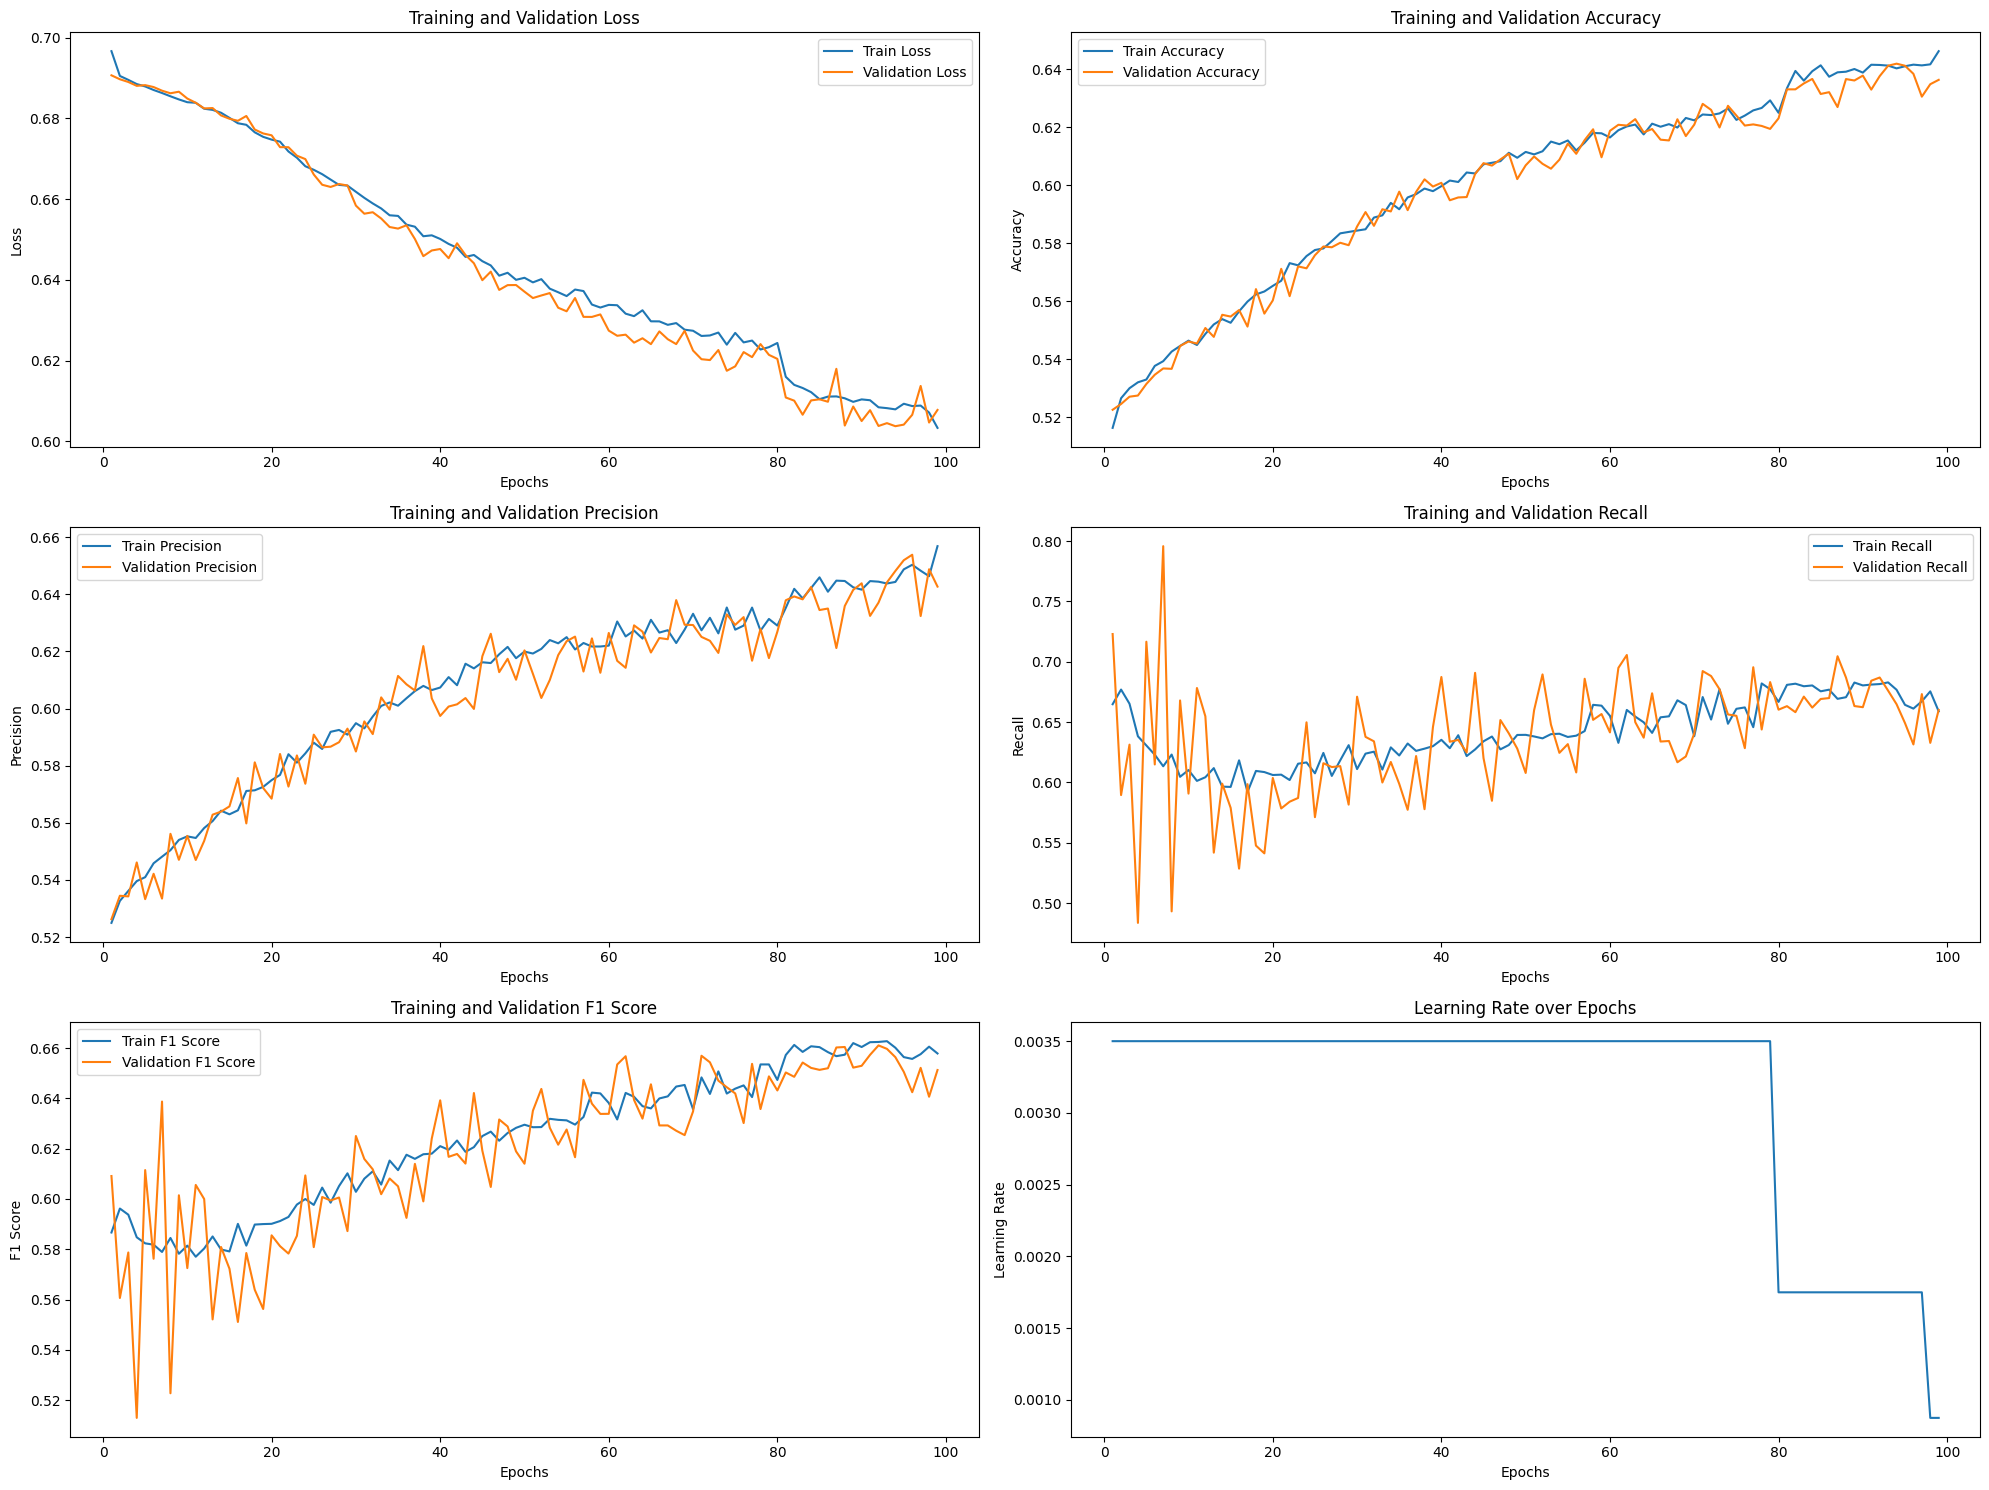

In [46]:

# Funkcia na vizualizáciu výsledkov tréningu a validácie
def plot_results(train_losses, val_losses, train_metrics, val_metrics, learning_rates):
    epochs = range(1, len(train_losses) + 1)  # Vytvorenie rozsahu epoch pre grafy
    
    plt.figure(figsize=(20, 15))  # Nastavenie veľkosti figure pre grafy

    # Graf pre straty
    plt.subplot(3, 2, 1)  # Prvá pozícia v matice 3x2 grafov
    plt.plot(epochs, train_losses, label='Train Loss')  # Plotenie strat pre tréning
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plotenie strat pre validáciu
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('Loss')  # Popis osi Y
    plt.title('Training and Validation Loss')  # Názov grafu
    plt.legend()  # Zobrazenie legendy pre grafy

    # Graf pre presnosť
    plt.subplot(3, 2, 2)  # Druhá pozícia v matice 3x2 grafov
    plt.plot(epochs, [m[0] for m in train_metrics], label='Train Accuracy')  # Plotenie presnosti pre tréning
    plt.plot(epochs, [m[0] for m in val_metrics], label='Validation Accuracy')  # Plotenie presnosti pre validáciu
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('Accuracy')  # Popis osi Y
    plt.title('Training and Validation Accuracy')  # Názov grafu
    plt.legend()  # Zobrazenie legendy pre grafy

    # Graf pre presnosť (precision)
    plt.subplot(3, 2, 3)  # Tretia pozícia v matice 3x2 grafov
    plt.plot(epochs, [m[1] for m in train_metrics], label='Train Precision')  # Plotenie presnosti pre tréning
    plt.plot(epochs, [m[1] for m in val_metrics], label='Validation Precision')  # Plotenie presnosti pre validáciu
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('Precision')  # Popis osi Y
    plt.title('Training and Validation Precision')  # Názov grafu
    plt.legend()  # Zobrazenie legendy pre grafy

    # Graf pre citlivosť (recall)
    plt.subplot(3, 2, 4)  # Štvrtá pozícia v matice 3x2 grafov
    plt.plot(epochs, [m[2] for m in train_metrics], label='Train Recall')  # Plotenie citlivosti pre tréning
    plt.plot(epochs, [m[2] for m in val_metrics], label='Validation Recall')  # Plotenie citlivosti pre validáciu
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('Recall')  # Popis osi Y
    plt.title('Training and Validation Recall')  # Názov grafu
    plt.legend()  # Zobrazenie legendy pre grafy

    # Graf pre F1 skóre
    plt.subplot(3, 2, 5)  # Piata pozícia v matice 3x2 grafov
    plt.plot(epochs, [m[3] for m in train_metrics], label='Train F1 Score')  # Plotenie F1 skóre pre tréning
    plt.plot(epochs, [m[3] for m in val_metrics], label='Validation F1 Score')  # Plotenie F1 skóre pre validáciu
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('F1 Score')  # Popis osi Y
    plt.title('Training and Validation F1 Score')  # Názov grafu
    plt.legend()  # Zobrazenie legendy pre grafy

    # Graf pre learning rate
    plt.subplot(3, 2, 6)  # Šiesta pozícia v matice 3x2 grafov
    plt.plot(epochs, learning_rates)  # Plotenie learning rate počas epoch
    plt.xlabel('Epochs')  # Popis osi X
    plt.ylabel('Learning Rate')  # Popis osi Y
    plt.title('Learning Rate over Epochs')  # Názov grafu

    plt.tight_layout()  # Upraví rozloženie grafov, aby sa neprekrývali
    plt.show()  # Zobrazenie grafov

# Volanie funkcie na vykreslenie výsledkov
plot_results(train_losses, val_losses, train_metrics, val_metrics, learning_rates)


## Robiť predikcie na náhodných testovacích dátach

In [47]:

# Funkcia na generovanie náhodných dát
def generate_random_data(num_samples):
    random_data = {
        'Customer_Age': np.random.randint(18, 70, num_samples),  # Náhodné veky zákazníkov
        'Age_Group_Encoded': np.random.randint(0, 4, num_samples),  # Náhodné kódovanie vekových skupín
        'Country_Encoded': np.random.randint(0, len(df['Country'].unique()), num_samples),  # Náhodné kódovanie krajín
        'State_Encoded': np.random.randint(0, len(df['State'].unique()), num_samples),  # Náhodné kódovanie štátov
        'Product_Category_Encoded': np.random.randint(0, len(df['Product_Category'].unique()), num_samples),  # Náhodné kódovanie kategórií produktov
        'Sub_Category_Encoded': np.random.randint(0, len(df['Sub_Category'].unique()), num_samples),  # Náhodné kódovanie podkategórií produktov
        'Order_Quantity': np.random.randint(1, 100, num_samples),  # Náhodné množstvá objednávok
        'Profit': np.random.uniform(-500, 500, num_samples),  # Náhodné zisky
        'Revenue': np.random.uniform(1000, 5000, num_samples),  # Náhodné tržby
    }
    return pd.DataFrame(random_data)  # Vytvorenie DataFrame z náhodných dát

# Generovanie nových dát
num_samples = 10  # Počet nových vzoriek
new_data = generate_random_data(num_samples)  # Vytvorenie nových dát

# Škálovanie nových dát
X_new = new_data.values  # Prevod dát na numpy array
X_new_scaled = scaler.transform(X_new)  # Škálovanie nových dát pomocou predtým natrénovaného scaleru

# Konvertovanie na tensor
X_new_tensor = torch.FloatTensor(X_new_scaled)  # Prevod škálovaných dát na PyTorch tensor

# Predikcia
model.eval()  # Nastavenie modelu do evaluačného režimu
with torch.no_grad():  # Deaktivácia gradientov pre predikciu
    predictions = model(X_new_tensor).squeeze()  # Predikcia výstupov modelom
    predicted_probs = torch.sigmoid(predictions)  # Aplikácia sigmoid aktivačnej funkcie na získanie pravdepodobností
    predicted_labels = (predicted_probs >= 0.5).numpy()  # Prevod pravdepodobností na binárne predikcie

# Dekódovanie predikcií
decoded_predictions = ['Male' if label == 1 else 'Female' for label in predicted_labels]  # Prevod binárnych predikcií na textové štítky

# Zobrazenie predikcií
for i, pred in enumerate(decoded_predictions):
    print(f'Vzorka {i+1}: Predikcia: {pred}, Pravdepodobnosť: {predicted_probs[i].item():.4f}')  # Výpis predikcií a pravdepodobností

# Výpočet presnosti
y_new = np.random.randint(0, 2, num_samples)  # Simulácia skutočných štítkov pre nové dáta
accuracy = accuracy_score(y_new, predicted_labels)  # Výpočet presnosti na základe skutočných a predikovaných štítkov
print(f"Presnosť na testovacej množine: {accuracy:.4f}")  # Výpis presnosti


Vzorka 1: Predikcia: Female, Pravdepodobnosť: 0.3137
Vzorka 2: Predikcia: Male, Pravdepodobnosť: 1.0000
Vzorka 3: Predikcia: Male, Pravdepodobnosť: 0.9891
Vzorka 4: Predikcia: Male, Pravdepodobnosť: 0.7706
Vzorka 5: Predikcia: Male, Pravdepodobnosť: 0.8732
Vzorka 6: Predikcia: Male, Pravdepodobnosť: 1.0000
Vzorka 7: Predikcia: Male, Pravdepodobnosť: 1.0000
Vzorka 8: Predikcia: Male, Pravdepodobnosť: 0.8270
Vzorka 9: Predikcia: Male, Pravdepodobnosť: 1.0000
Vzorka 10: Predikcia: Male, Pravdepodobnosť: 0.5368
Presnosť na testovacej množine: 0.2000
